In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, Dropout
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *
from inception_v4 import *
from inception_resnet_v2 import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [48]:
WEIGHTS_PRESENCE_A_FILEPATH = os.path.join(MODELDIR, 'model-07a-presence-weights.hdf5')
HISTORY_PRESENCE_A_FILEPATH = os.path.join(MODELDIR, 'model-07a-presence-training-history.json')
WEIGHTS_PRESENCE_B_FILEPATH = os.path.join(MODELDIR, 'model-07b-presence-weights.hdf5')
HISTORY_PRESENCE_B_FILEPATH = os.path.join(MODELDIR, 'model-07b-presence-training-history.json')
WEIGHTS_PRESENCE_C_FILEPATH = os.path.join(MODELDIR, 'model-07c-presence-weights.hdf5')
HISTORY_PRESENCE_C_FILEPATH = os.path.join(MODELDIR, 'model-07c-presence-training-history.json')

WEIGHTS_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-01-weights.hdf5')

In [3]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [4]:
with open(os.path.join(PROCDIR, 'data_train_val_07.pkl'), 'rb') as f:
    (data_images_train, data_images_val, 
     data_presence_train, data_presence_val, 
     data_masks_train, data_masks_val) = pickle.load(f)

print('image shapes:', data_images_train.shape, data_images_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

image shapes: (16188, 64, 96, 1) (239, 64, 96, 1)
presence label shapes: (16188,) (239,)
mask shapes: (16188, 64, 96) (239, 64, 96)


## presence model a

In [8]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 64, 96
    img_channels = 1

    blocks_per_group = 3
    nb_total_blocks = 5 * blocks_per_group
    
    images_presence_a = Input(shape=(img_rows, img_cols, img_channels))

    x_a = Convolution2D(4, 3, 3, subsample=(1, 1),
                        init='he_normal', border_mode='same', dim_ordering='tf')(images_presence_a)
    x_a = BatchNormalization(axis=3)(x_a)
    x_a = Activation('relu')(x_a)

    for i in range(0, blocks_per_group):
        nb_filters = 4
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                              block=i, nb_total_blocks=nb_total_blocks,
                                              subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                              block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                              subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                              block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                              subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                              block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                              subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x_a = stochastic_depth_residual_block(x_a, nb_filters=nb_filters,
                                              block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                              subsample_factor=subsample_factor)

    x_a = AveragePooling2D(pool_size=(4, 6), strides=None, border_mode='valid', dim_ordering='tf')(x_a)
    x_a = Dropout(0.5)(x_a)
    x_a = Flatten()(x_a)
    presence_a = Dense(1, activation='sigmoid')(x_a)

    model_presence_a = Model(input=images_presence_a, output=presence_a)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 5.8447065353393555
model compile time: 2.1409707069396973


## presence model a train

In [10]:
with tf.device('/gpu:0'):
    batch_size = 256
    nb_epoch = 3
    history = model_presence_a.fit(data_images_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_val, data_presence_val), shuffle=True,
                                   callbacks=[])

Train on 16188 samples, validate on 239 samples
Epoch 1/3
16188/16188 [==============================] - 27s - loss: 0.8277 - acc: 0.5471 - val_loss: 1.5988 - val_acc: 0.3975
Epoch 2/3
16188/16188 [==============================] - 25s - loss: 0.6601 - acc: 0.6029 - val_loss: 0.5436 - val_acc: 0.7741
Epoch 3/3
16188/16188 [==============================] - 26s - loss: 0.6314 - acc: 0.6394 - val_loss: 0.4669 - val_acc: 0.8368


## presence model b

In [5]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 64, 96
    img_channels = 1

    nb_filters_reduction_factor = 8
    
    # in original inception-v4, these are 4, 7, 3, respectively
    num_A_blocks = 1
    num_B_blocks = 2
    num_C_blocks = 1
    
    images_presence_b = Input(shape=(img_rows, img_cols, img_channels))

    x_b = inception_v4_stem(images_presence_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_A_blocks):
        x_b = inception_v4_A(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_b = inception_v4_reduction_A(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_B_blocks):
        x_b = inception_v4_B(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x_b = inception_v4_reduction_B(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_C_blocks):
        x_b = inception_v4_C(x_b, nb_filters_reduction_factor=nb_filters_reduction_factor)

    x_b = AveragePooling2D(pool_size=(4, 6), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x_b)
    x_b = Dropout(0.5)(x_b)
    x_b = Flatten()(x_b)
    presence_b = Dense(1, activation='sigmoid')(x_b)

    model_presence_b = Model(input=images_presence_b, output=presence_b)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 2.7817342281341553
model compile time: 0.6714768409729004


## presence model b train

In [8]:
with tf.device('/gpu:0'):
    batch_size = 256
    nb_epoch = 3
    history = model_presence_b.fit(data_images_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_val, data_presence_val), shuffle=True,
                                   callbacks=[])

Train on 16188 samples, validate on 239 samples
Epoch 1/3
16188/16188 [==============================] - 78s - loss: 0.6760 - acc: 0.5951 - val_loss: 0.7355 - val_acc: 0.3975
Epoch 2/3
16188/16188 [==============================] - 78s - loss: 0.6725 - acc: 0.5961 - val_loss: 0.7089 - val_acc: 0.3975
Epoch 3/3
16188/16188 [==============================] - 77s - loss: 0.6338 - acc: 0.6441 - val_loss: 0.5489 - val_acc: 0.7155


## presence model c

In [5]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 64, 96
    img_channels = 1

    nb_filters_reduction_factor = 8
    
    # in original inception-resnet-v2, these are 5, 10, 5, respectively
    num_A_blocks = 1
    num_B_blocks = 2
    num_C_blocks = 1
    
    images_presence = Input(shape=(img_rows, img_cols, img_channels))

    x = inception_resnet_v2_stem(images_presence, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_A_blocks):
        x = inception_resnet_v2_A(x, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x = inception_resnet_v2_reduction_A(x, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_B_blocks):
        x = inception_resnet_v2_B(x, nb_filters_reduction_factor=nb_filters_reduction_factor)
    x = inception_resnet_v2_reduction_B(x, nb_filters_reduction_factor=nb_filters_reduction_factor)
    for i in range(num_C_blocks):
        x = inception_resnet_v2_C(x, nb_filters_reduction_factor=nb_filters_reduction_factor)

    x = AveragePooling2D(pool_size=(4, 6), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    presence = Dense(1, activation='sigmoid')(x)

    model_presence_c = Model(input=images_presence, output=presence)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence_c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 2.50315260887146
model compile time: 0.37612199783325195


## presence model c train

In [7]:
with tf.device('/gpu:0'):
    batch_size = 256
    nb_epoch = 3
    history = model_presence_c.fit(data_images_train, data_presence_train,
                                   batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                   validation_data=(data_images_val, data_presence_val), shuffle=True,
                                   callbacks=[])

Train on 16188 samples, validate on 239 samples
Epoch 1/3
16188/16188 [==============================] - 69s - loss: 1.7907 - acc: 0.5640 - val_loss: 0.7320 - val_acc: 0.3975
Epoch 2/3
16188/16188 [==============================] - 69s - loss: 0.6655 - acc: 0.6030 - val_loss: 0.6802 - val_acc: 0.4854
Epoch 3/3
16188/16188 [==============================] - 69s - loss: 0.6139 - acc: 0.6647 - val_loss: 0.5215 - val_acc: 0.8033


## segmentation model a

In [45]:
with tf.device('/gpu:1'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows_segment, img_cols_segment = 128, 192
    img_channels = 1

    blocks_per_group = 4
    nb_total_blocks = 5 * blocks_per_group

    images_segment = Input(shape=(img_rows_segment, img_cols_segment, img_channels))

    x = Convolution2D(8, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_segment)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f2 = x
    f2 = UpSampling2D(size=(2, 2), dim_ordering='tf')(f2)
    f2 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f2)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f4 = x
    f4 = UpSampling2D(size=(4, 4), dim_ordering='tf')(f4)
    f4 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f4)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f8 = x
    f8 = UpSampling2D(size=(8, 8), dim_ordering='tf')(f8)
    f8 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f8)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f16 = x
    f16 = UpSampling2D(size=(16, 16), dim_ordering='tf')(f16)
    f16 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f16)

    segmentation = merge([f16, f8, f4, f2], mode='concat', concat_axis=-1)
    segmentation = Convolution2D(1, 1, 1,
                                 activation='sigmoid',
                                 init='uniform', border_mode='same', dim_ordering='tf')(segmentation)
    segmentation = Reshape((img_rows_segment, img_cols_segment))(segmentation)

    model_segment = Model(input=images_segment, output=segmentation)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_segment.compile(optimizer='adam', loss=binaryCE, metrics=[dice_coeff])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 59.87167453765869
model compile time: 4.457046747207642


## segmentation model a train

In [10]:
with tf.device('/gpu:1'):
    batch_size = 128
    nb_epoch = 3
    history = model_segment.fit(data_images_train, data_masks_train,
                                  batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                  validation_data=(data_images_val, data_masks_val), shuffle=True,
                                  callbacks=[])

Train on 16188 samples, validate on 239 samples
Epoch 1/3
16188/16188 [==============================] - 42s - loss: 0.1342 - dice_coeff: 0.0126 - val_loss: 0.0592 - val_dice_coeff: 0.2212
Epoch 2/3
16188/16188 [==============================] - 42s - loss: 0.0472 - dice_coeff: 0.1985 - val_loss: 0.0443 - val_dice_coeff: 0.4655
Epoch 3/3
16188/16188 [==============================] - 42s - loss: 0.0417 - dice_coeff: 0.3191 - val_loss: 0.0381 - val_dice_coeff: 0.6023


## test

In [46]:
with open(os.path.join(PROCDIR, 'data_train_val_01.pkl'), 'rb') as f:
    data_images_train, data_masks_train, data_images_val, data_masks_val = pickle.load(f)
    
data_presence_train = np.sum(data_masks_train, axis=(-2, -1)) != 0
data_presence_val = np.sum(data_masks_val, axis=(-2, -1)) != 0

print('image shapes:', data_images_train.shape, data_images_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

image shapes: (5155, 128, 192, 1) (480, 128, 192, 1)
presence label shapes: (5155,) (480,)
mask shapes: (5155, 128, 192) (480, 128, 192)


In [9]:
with tf.device('/gpu:0'):
    model_presence_a.load_weights(WEIGHTS_PRESENCE_A_FILEPATH)
    model_presence_b.load_weights(WEIGHTS_PRESENCE_B_FILEPATH)
    #model_presence_c.load_weights(WEIGHTS_PRESENCE_C_FILEPATH)

In [49]:
with tf.device('/gpu:1'):
    model_segment.load_weights(WEIGHTS_SEGMENT_FILEPATH)

In [55]:
image.shape

(128, 192, 1)

presence prediction a:  [ 0.53293562] [ True]
presence prediction b:  [ 0.95686942] [ True]
presence prediction (combined):  0.744902521372 True


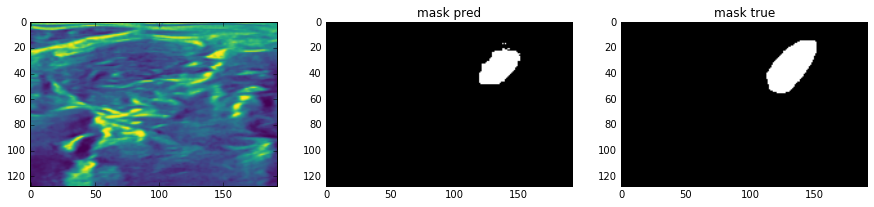

In [71]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)

image = data_images_val[rand_i:rand_i+1]
image_resized = np.expand_dims(np.expand_dims(imresize(image[0,:,:,0], size=(img_rows, img_cols), interp='bilinear'), axis=0), axis=3)
mask = data_masks_val[rand_i, :, :]

presence_a = model_presence_a.predict(image_resized, verbose=0)[0]
presence_b = model_presence_b.predict(image_resized, verbose=0)[0]
print('presence prediction a: ', presence_a, presence_a > 0.5)
print('presence prediction b: ', presence_b, presence_b > 0.5)
presence = np.mean([presence_a, presence_b])
print('presence prediction (combined): ', presence, presence > 0.5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image[0,:,:,0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model_segment.predict(image, verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(mask, cmap=plt.cm.bone)

In [73]:
# presence classification metrics
images_resized = []
for i in range(data_images_val.shape[0]):
    images_resized.append(np.expand_dims(imresize(data_images_val[i,:,:,0], size=(img_rows, img_cols), interp='bilinear'), axis=2))
images_resized = np.array(images_resized, dtype=np.float32)
presence_a = model_presence_a.predict(images_resized, verbose=0)
presence_b = model_presence_b.predict(images_resized, verbose=0)
print('presence model a')
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence_a > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence_a), '\n')
print(classification_report(data_presence_val, presence_a > 0.5, target_names=['BP not present', 'BP present']), '\n')
print('presence model b')
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence_b > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence_b), '\n')
print(classification_report(data_presence_val, presence_b > 0.5, target_names=['BP not present', 'BP present']), '\n')
print('presence model (combined)')
presence = (presence_a + presence_b) / 2
print('confusion matrix:\n', confusion_matrix(data_presence_val, presence > 0.5), '\n')
print('ROC AUC: ', roc_auc_score(data_presence_val, presence), '\n')
print(classification_report(data_presence_val, presence > 0.5, target_names=['BP not present', 'BP present']), '\n')

presence model a
confusion matrix:
 [[234  46]
 [ 32 168]] 

ROC AUC:  0.877678571429 

                precision    recall  f1-score   support

BP not present       0.88      0.84      0.86       280
    BP present       0.79      0.84      0.81       200

   avg / total       0.84      0.84      0.84       480
 

presence model b
confusion matrix:
 [[234  46]
 [ 26 174]] 

ROC AUC:  0.913410714286 

                precision    recall  f1-score   support

BP not present       0.90      0.84      0.87       280
    BP present       0.79      0.87      0.83       200

   avg / total       0.85      0.85      0.85       480
 

presence model (combined)
confusion matrix:
 [[233  47]
 [ 31 169]] 

ROC AUC:  0.906892857143 

                precision    recall  f1-score   support

BP not present       0.88      0.83      0.86       280
    BP present       0.78      0.84      0.81       200

   avg / total       0.84      0.84      0.84       480
 



In [74]:
preds_segment = model_segment.predict(data_images_val, verbose=0)
np.mean(2 * np.sum(data_masks_val * preds_segment>0.5) / (np.sum(data_masks_val) + np.sum(preds_segment>0.5) + 1e-6), axis=None)

0.62895139489265706

In [90]:
images_resized = []
for i in range(data_images_val.shape[0]):
    images_resized.append(np.expand_dims(imresize(data_images_val[i,:,:,0], size=(img_rows, img_cols), interp='bilinear'), axis=2))
images_resized = np.array(images_resized, dtype=np.float32)
preds_presence_a = model_presence_a.predict(images_resized, verbose=0)
preds_presence_b = model_presence_b.predict(images_resized, verbose=0)
preds_presence = (preds_presence_a + preds_presence_b) / 2
preds_segment = model_segment.predict(data_images_val, verbose=0)
preds_mod = []
for i in range(preds_segment.shape[0]):
    if preds_presence[i] < 0.1:
        preds_mod.append(preds_segment[i,:,:]>0.9)
    elif preds_presence[i] > 0.7:
        preds_mod.append(preds_segment[i,:,:]>0.3)
    else:
        preds_mod.append(preds_segment[i,:,:]>0.5)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.65402512000880109

In [ ]:
with open(os.path.join(SUBMITDIR, 'model-07.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])

    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        img_filepath = os.path.join(folder, img_file)
        image = io.imread(img_filepath) / 255.0
        image_resized_presence = np.expand_dims(imresize(image, size=(img_rows, img_cols), interp='bilinear'), axis=3)
        image_resized_segment = np.expand_dims(imresize(image, size=(img_rows_segment, img_cols_segment), interp='bilinear'), axis=3)
        presence_a = model_presence_a.predict(np.array([image_resized_presence], dtype=np.float32), verbose=0)[0]
        presence_b = model_presence_b.predict(np.array([image_resized_presence], dtype=np.float32), verbose=0)[0]
        presence = (presence_a + presence_b) / 2
        mask_pred = model_segment.predict(np.array([image_resized_segment], dtype=np.float32), verbose=0)
        if presence < 0.1:
            mask_pred = mask_pred[0, :, :] > 0.9
        elif presence > 0.7:
            mask_pred = mask_pred[0, :, :] > 0.3
        else:
            mask_pred = mask_pred[0, :, :] > 0.5
        mask_pred_orig_size = imresize(mask_pred, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

  5%|▌         | 280/5508 [00:27<09:30,  9.17it/s]